<a href="https://colab.research.google.com/github/amsa10/Conv-segmentation/blob/main/segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gdown
!gdown --id 1beO8YaOR5ZNPtV4ftmC8bzlygjBaJGrX -O img.tiff

In [ ]:
pip install patchify rasterio matplotlib


/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Metadata: {'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 14456, 'height': 1800, 'count': 1, 'crs': None, 'transform': Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0)}


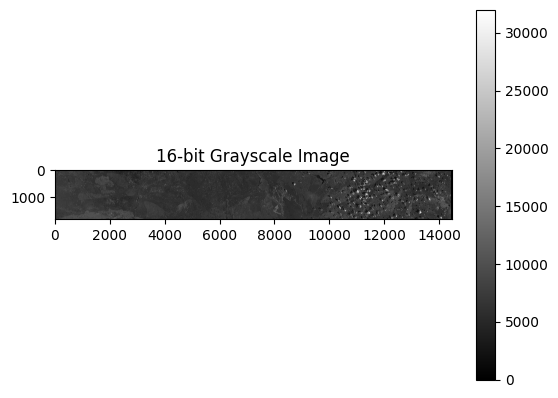

In [ ]:
import rasterio
import matplotlib.pyplot as plt

# Open the TIFF file
with rasterio.open('/content/img.tiff') as src:
    # Read the image data
    img_array = src.read(1)  # Read the first band

    # Get image metadata
    metadata = src.meta
    print('Metadata:', metadata)

# Display the image using matplotlib
plt.imshow(img_array, cmap='gray')
plt.title('16-bit Grayscale Image')
plt.colorbar()  # To show the color scale
plt.show()




In [ ]:
from tensorflow.keras.losses import Loss

class SoftJaccardLoss(Loss):
    def call(self, y_true, y_pred):
        epsilon = 1e-7
        intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
        union = tf.reduce_sum(y_true + y_pred, axis=[1, 2, 3]) - intersection
        loss = 1 - (intersection + epsilon) / (union + epsilon)
        return tf.reduce_mean(loss)


In [ ]:
from tensorflow.keras.optimizers import Adam

# Initialize Adam optimizer
optimizer = Adam(learning_rate=1e-4)


In [ ]:
import requests
from tqdm import tqdm
import tensorflow as tf
# Download the pretrained model
model_url = 'https://model/download'
model_path = '/content/pretrained_model.h5'

response = requests.get(model_url, stream=True)
if response.status_code == 200:
    total_size = int(response.headers.get('content-length', 0))
    with open(model_path, 'wb') as file:
        with tqdm(total=total_size, unit='B', unit_scale=True, unit_divisor=1024) as progress_bar:
            for chunk in response.iter_content(chunk_size=8192):
                if chunk:
                    file.write(chunk)
                    progress_bar.update(len(chunk))
    print(f"File downloaded successfully and saved to {model_path}")
else:
    print(f"Failed to download file, status code: {response.status_code}")

# Load the model
model = tf.keras.models.load_model(model_path, compile=False)


100%|██████████| 418M/418M [05:53<00:00, 1.24MB/s]


File downloaded successfully and saved to /content/pretrained_model.h5


In [ ]:
import numpy as np
from PIL import Image
from skimage.transform import resize
import tensorflow as tf  # Or import your model library
import matplotlib.pyplot as plt

# Load the image
image_path = '/content/img.tiff'
image = Image.open(image_path)

# Convert to NumPy array
img_array = np.array(image)

# Normalize to range [0, 1]
img_array = img_array / 65535.0

# Expand dimensions for single-channel to RGBNIR (assuming dummy channels)
rgbnir_array = np.stack([img_array] * 4, axis=-1)  # Assuming dummy RGBNIR

# Define functions to extract patches and resize them
def extract_patches(img, patch_size, resize_to):
    patches = []
    h, w, _ = img.shape
    for i in range(0, h - patch_size + 1, patch_size):
        for j in range(0, w - patch_size + 1, patch_size):
            patch = img[i:i+patch_size, j:j+patch_size]
            patch_resized = resize(patch, resize_to, mode='reflect')
            patches.append(patch_resized)
    return np.array(patches)

# Extract and resize patches
patches = extract_patches(rgbnir_array, patch_size=384, resize_to=(192, 192, 4))

# Load your pretrained model
# Replace this with your model loading code
predictions = model.predict(patches)

# Predict cloud masks
predictions = model.predict(patches)





5/5 ━━━━━━━━━━━━━━━━━━━━ 91s 17s/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 85s 16s/step


In [ ]:
predictions.shape

(148, 192, 192, 1)

Full cloud mask saved to /content/cloud_mask_full.png


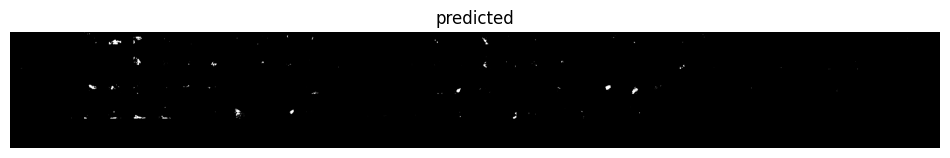

In [ ]:
import numpy as np
import tensorflow as tf
from PIL import Image
from skimage.transform import resize
import matplotlib.pyplot as plt

# Metadata
original_width = 14456
original_height = 1800
patch_size = 384
resized_patch_size = 192



# Define the number of patches
num_patches_x = original_width // patch_size
num_patches_y = original_height // patch_size

# Initialize arrays for reconstruction
cloud_mask_full = np.zeros((original_height, original_width), dtype=np.float32)
count_map = np.zeros((original_height, original_width), dtype=np.float32)


# Reconstruct the full image
for i in range(num_patches_y):
    for j in range(num_patches_x):
        start_y = i * patch_size
        start_x = j * patch_size
        end_y = start_y + resized_patch_size
        end_x = start_x + resized_patch_size

        # Ensure the end indices do not exceed the image dimensions
        if end_y > original_height:
            end_y = original_height
        if end_x > original_width:
            end_x = original_width

        # Calculate patch indices in predictions
        patch_idx = i * num_patches_x + j
        patch = predictions[patch_idx, :, :, 0]

        # Add patch to full image and update count map
        cloud_mask_full[start_y:end_y, start_x:end_x] += patch
        count_map[start_y:end_y, start_x:end_x] += 1

# Normalize the full cloud mask
cloud_mask_full /= np.maximum(count_map, 1)

# Save the cloud mask as an image
output_mask_path = '/content/cloud_mask_full.png'
plt.imsave(output_mask_path, cloud_mask_full, cmap='gray')

print(f"Full cloud mask saved to {output_mask_path}")

# Display the full cloud mask
plt.figure(figsize=(12, 6))
plt.title('predicted')
plt.imshow(cloud_mask_full, cmap='gray')
plt.axis('off')
plt.show()


Full cloud mask saved to /content/cloud_mask_full.png


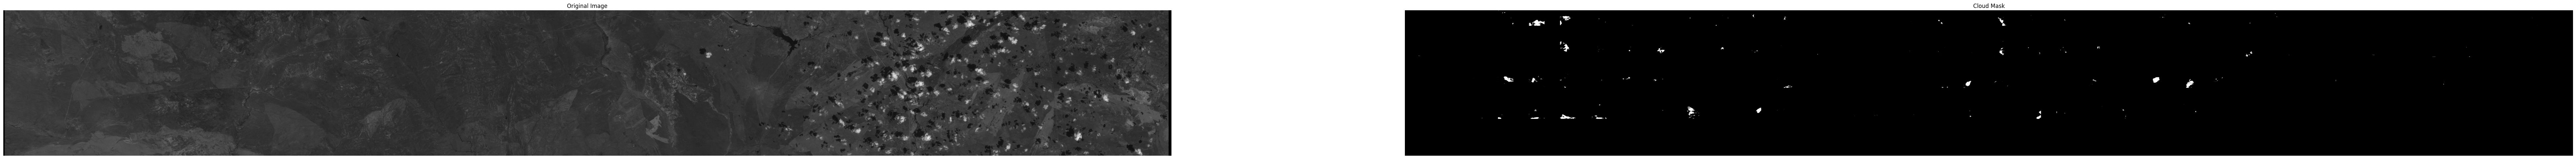

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Load the original image
original_image_path = '/content/img.tiff'
original_image = Image.open(original_image_path)

# Assuming cloud_mask_full is already computed and normalized
# Normalize the image to the [0, 255] range for saving
cloud_mask_normalized = (cloud_mask_full - cloud_mask_full.min()) / (cloud_mask_full.max() - cloud_mask_full.min())
cloud_mask_uint8 = (cloud_mask_normalized * 255).astype(np.uint8)

# Save the cloud mask using PIL
output_mask_path = '/content/cloud_mask_full.png'
Image.fromarray(cloud_mask_uint8, mode='L').save(output_mask_path)

print(f"Full cloud mask saved to {output_mask_path}")

# Display the original image and cloud mask side by side
plt.figure(figsize=(100, 100))

# Display the original image
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(original_image, cmap='gray')
plt.axis('off')

# Display the cloud mask
plt.subplot(1, 2, 2)
plt.title('Cloud Mask')
plt.imshow(cloud_mask_full, cmap='gray', vmin=0, vmax=1)
plt.axis('off')

plt.show()
